In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter

### Importowanie danych

In [2]:
data = np.load("./olivetti_faces.npy")
target = []

for i in range(40):
    target.extend([i for _ in range(10)])

### Prezentacja 40 unikalnych osób

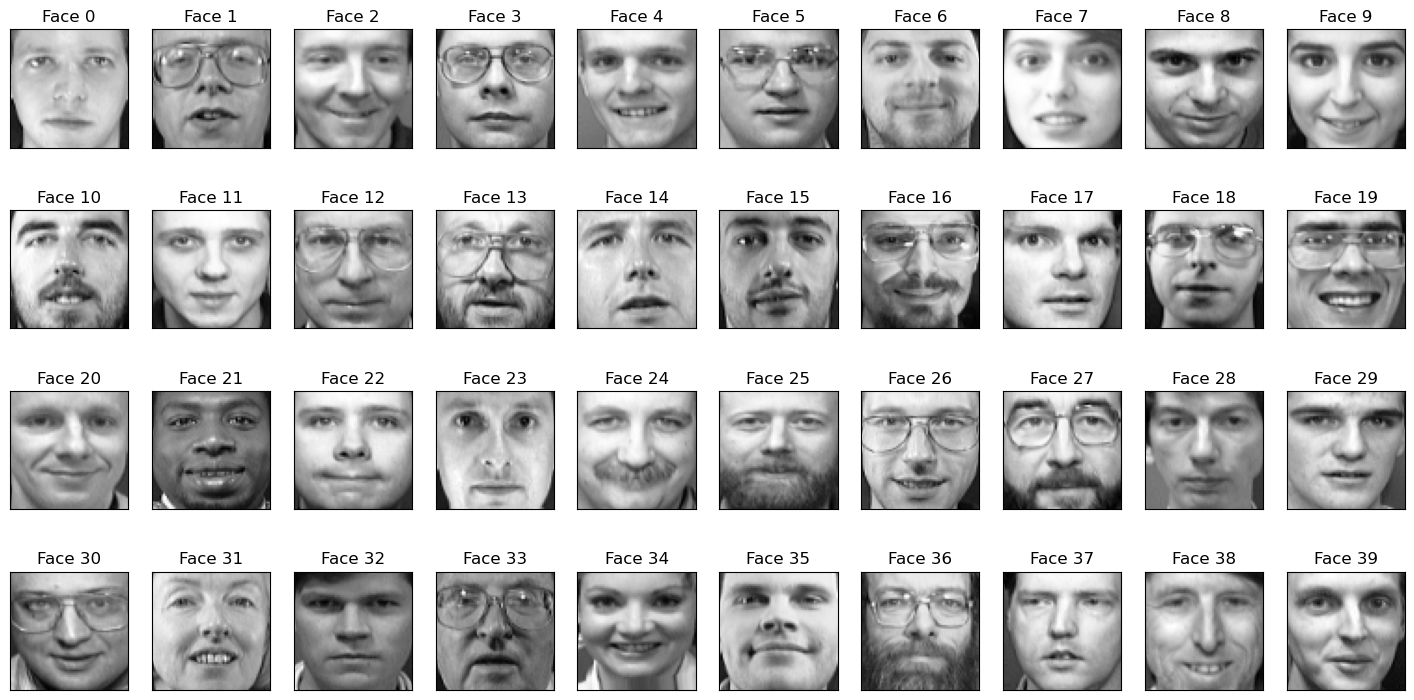

In [3]:
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
ax = ax.flatten()

for i in range(40):
    ax[i].imshow(data[i * 10], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {i}")

### Przykład twarzy dla trzech wybranych osób

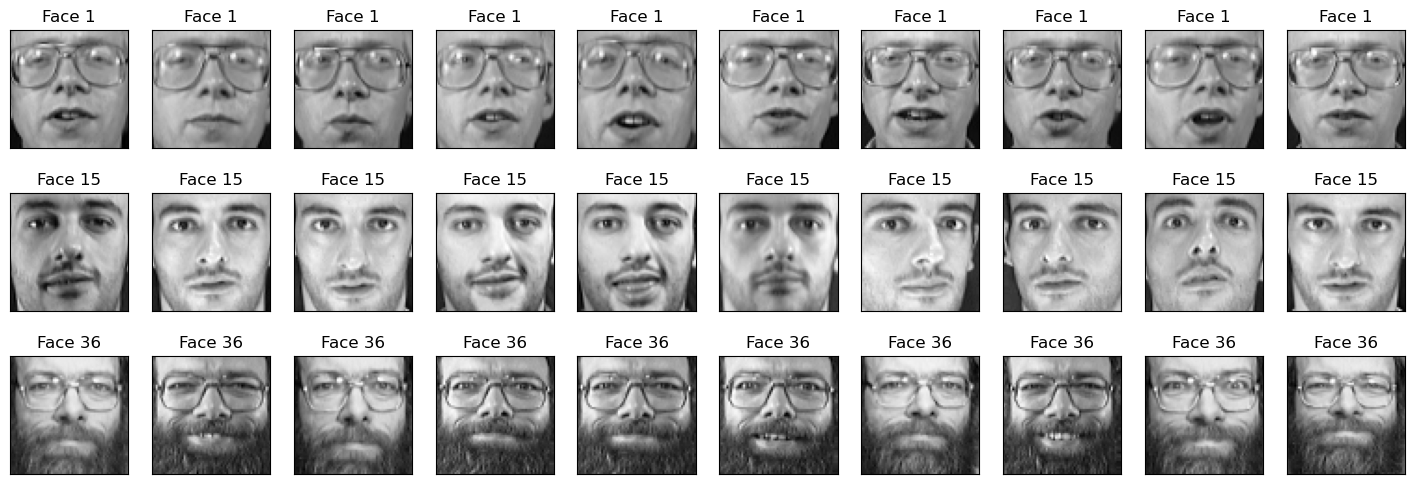

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(18, 6))

ids = [1, 15, 36]

for i in range(len(ids)):
    for j in range(10):
        ax[i, j].imshow(data[ids[i] * 10 + j], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f"Face {ids[i]}")

### Zamiana zdjęć na wektory cech

In [5]:
feature_vectors = data.reshape((data.shape[0], 64 * 64))
feature_vectors.shape

(400, 4096)

### Podział na dane treningowe i dane testowe

In [6]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, target, test_size=0.3,
                                                    random_state=42, stratify=target)
X_train.shape

(280, 4096)

## Eigenfaces

### Obliczenie twarzy średniej

In [7]:
mean_face = np.mean(X_train, axis=0)

Text(0.5, 1.0, 'Twarz średni')

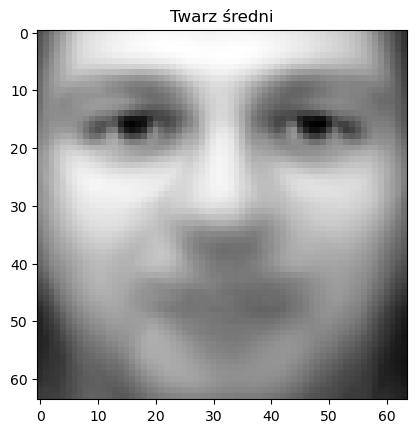

In [8]:
plt.imshow(mean_face.reshape(64, 64), cmap='gray')
plt.title(f"Twarz średni")

### Odjęcie twarzy średniej od twarzy treningowych

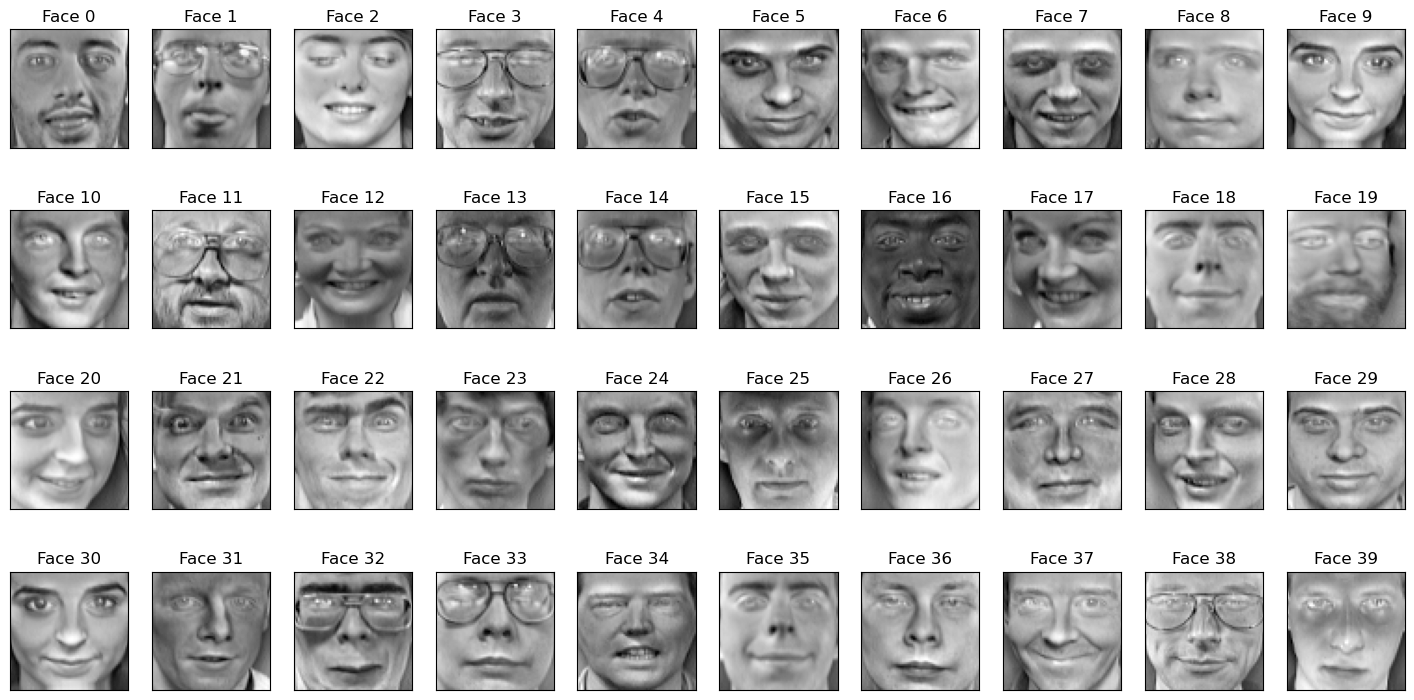

In [9]:
feature_vectors_subtracted = X_train - mean_face

fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
ax = ax.flatten()

for i in range(40):
    ax[i].imshow(feature_vectors_subtracted[i * 7].reshape(64, 64), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {i}")

### Obliczenie macierzy kowariancji

In [10]:
covariance_matrix = (feature_vectors_subtracted.dot(feature_vectors_subtracted.T) / len(feature_vectors_subtracted))
covariance_matrix.shape

(280, 280)

### Obliczenie wartości i wektorów własnych

In [11]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

eig_pairs = sorted(zip(eigenvalues, eigenvectors.T), reverse=True)
_, eigenvectors_sort = zip(*eig_pairs)
eigenvectors_sort = np.array(eigenvectors_sort)[:100]

eigenvectors_sort.shape

(100, 280)

In [12]:
eigenfaces = preprocessing.normalize((feature_vectors_subtracted.T @ eigenvectors_sort.T).T)
eigenfaces.shape

(100, 4096)

### Wyświetlenie wszystkich twarzy własnych

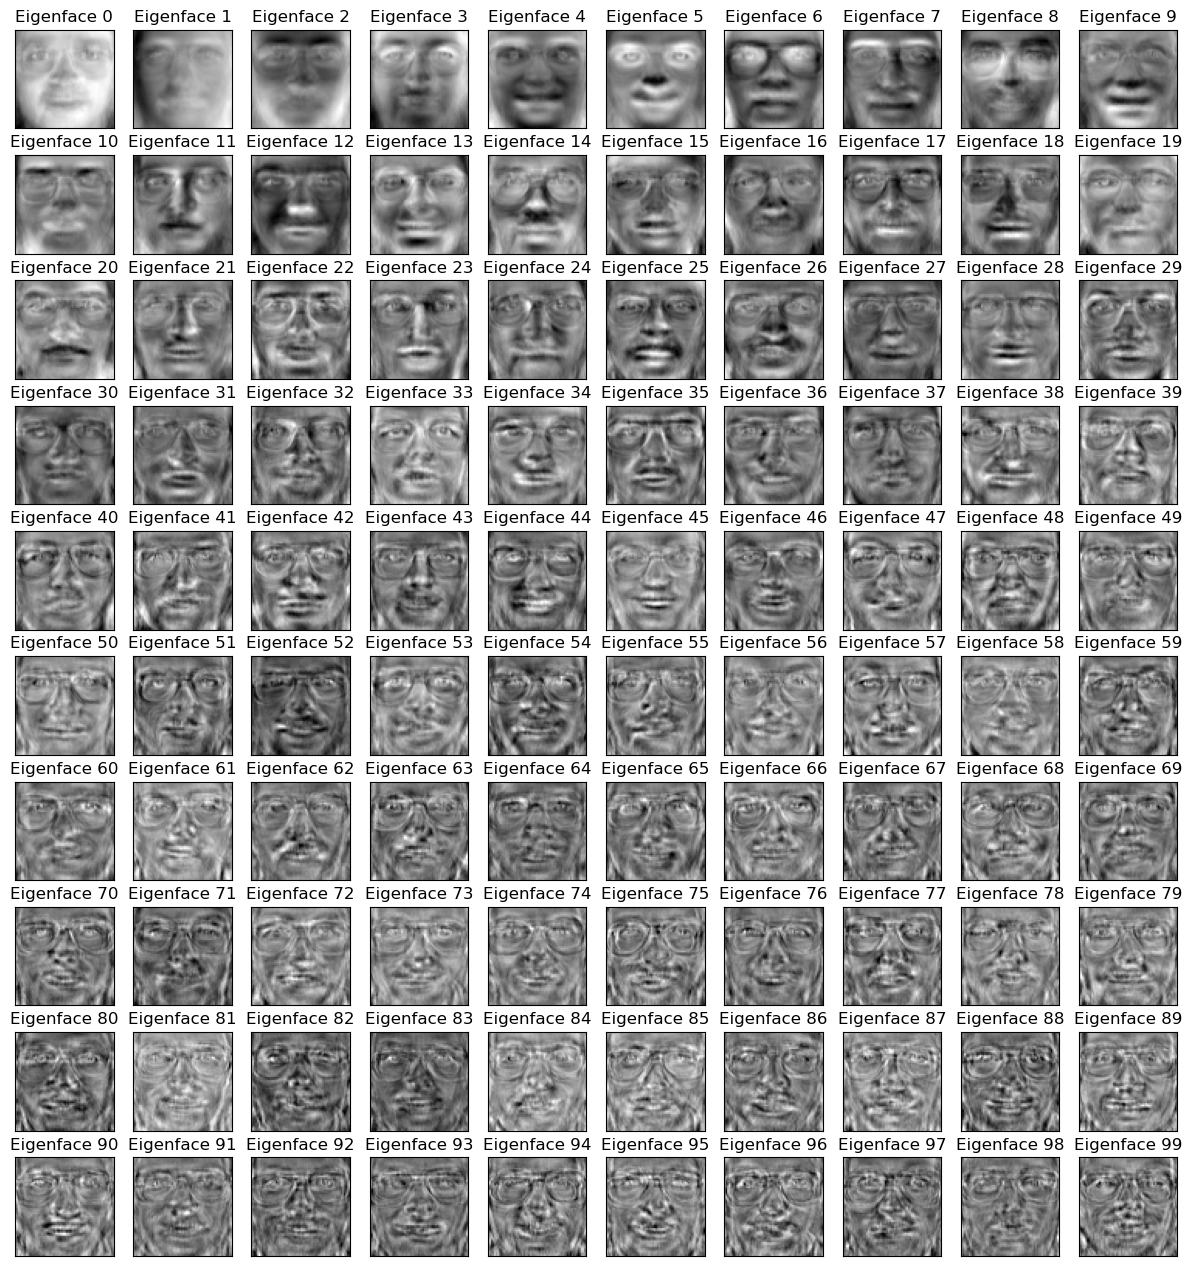

In [13]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 16))
ax = ax.flatten()
for i in range(len(eigenfaces)):
    ax[i].imshow(eigenfaces[i].reshape(64, 64), cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Eigenface {i}")

### Projekcja wektorów cech na nową przestrzeń

In [14]:
transformed_faces = np.dot(eigenfaces, feature_vectors_subtracted.T).T
transformed_faces.shape

(280, 100)

### Rozpoznawanie twarzy (istniejące zdjęcie w bazie)

In [15]:
subtracted_vector = X_train[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

epsilon: 1.1386189e-05


### Rekonstrukcja twarzy

Text(0.5, 1.0, 'Twarz odtworzona')

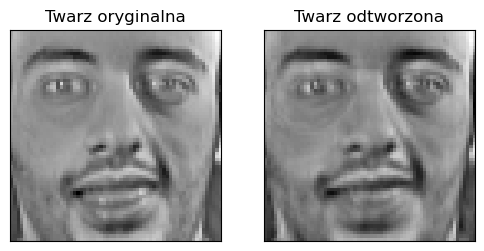

In [16]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (nowe zdjęcie osoby istniejącej w bazie)

In [17]:
subtracted_vector = X_test[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

epsilon: 2.633781


### Rekonstrukcja twarzy

Text(0.5, 1.0, 'Twarz odtworzona')

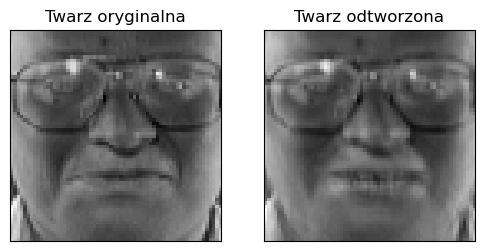

In [18]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki najbliższy sąsiad

In [ ]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 2

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) > theta):
        errors += 1
        continue

    if (y_train[np.argmin(epsilon)] != y_test[i]):
        errors += 1

print(f"Statystyka: {len(y_test) - errors}/{len(y_test)} poprawnych")#%%
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter

### Importowanie danych

In [ ]:
data = np.load("./olivetti_faces.npy")
target = []

for i in range(40):
    target.extend([i for _ in range(10)])

### Prezentacja 40 unikalnych osób

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
ax = ax.flatten()

for i in range(40):
    ax[i].imshow(data[i * 10], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {i}")

### Przykład twarzy dla trzech wybranych osób

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=10, figsize=(18, 6))

ids = [1, 15, 36]

for i in range(len(ids)):
    for j in range(10):
        ax[i, j].imshow(data[ids[i] * 10 + j], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f"Face {ids[i]}")

### Zamiana zdjęć na wektory cech

In [ ]:
feature_vectors = data.reshape((data.shape[0], 64 * 64))
feature_vectors.shape

### Podział na dane treningowe i dane testowe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, target, test_size=0.3,
                                                    random_state=42, stratify=target)
X_train.shape

## Eigenfaces

### Obliczenie twarzy średniej

In [ ]:
mean_face = np.mean(X_train, axis=0)

In [ ]:
plt.imshow(mean_face.reshape(64, 64), cmap='gray')
plt.title(f"Twarz średni")

### Odjęcie twarzy średniej od twarzy treningowych

In [ ]:
feature_vectors_subtracted = X_train - mean_face

fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
ax = ax.flatten()

for i in range(40):
    ax[i].imshow(feature_vectors_subtracted[i * 7].reshape(64, 64), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Face {i}")

### Obliczenie macierzy kowariancji

In [ ]:
covariance_matrix = (feature_vectors_subtracted.dot(feature_vectors_subtracted.T) / len(feature_vectors_subtracted))
covariance_matrix.shape

### Obliczenie wartości i wektorów własnych

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

eig_pairs = sorted(zip(eigenvalues, eigenvectors.T), reverse=True)
_, eigenvectors_sort = zip(*eig_pairs)
eigenvectors_sort = np.array(eigenvectors_sort)[:100]

eigenvectors_sort.shape

In [ ]:
eigenfaces = preprocessing.normalize((feature_vectors_subtracted.T @ eigenvectors_sort.T).T)
eigenfaces.shape

### Wyświetlenie wszystkich twarzy własnych

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 16))
ax = ax.flatten()
for i in range(len(eigenfaces)):
    ax[i].imshow(eigenfaces[i].reshape(64, 64), cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"Eigenface {i}")

### Projekcja wektorów cech na nową przestrzeń

In [ ]:
transformed_faces = np.dot(eigenfaces, feature_vectors_subtracted.T).T
transformed_faces.shape

### Rozpoznawanie twarzy (istniejące zdjęcie w bazie)

In [ ]:
subtracted_vector = X_train[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

### Rekonstrukcja twarzy

In [ ]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (nowe zdjęcie osoby istniejącej w bazie)

In [ ]:
subtracted_vector = X_test[0] - mean_face
projected_vector = np.dot(eigenfaces, subtracted_vector)

epsilon = []
for face in transformed_faces:
    epsilon.append(np.linalg.norm(projected_vector - face))

print("epsilon: " + str(min(epsilon)))

### Rekonstrukcja twarzy

In [ ]:
reconstructed_face = np.dot(eigenfaces.T, projected_vector)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(subtracted_vector.reshape(64, 64), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f"Twarz oryginalna")

ax[1].imshow(reconstructed_face.reshape(64, 64), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Twarz odtworzona")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki najbliższy sąsiad

In [ ]:
errors = 0

temp_norms = []
for i in transformed_faces:
    for j in transformed_faces:
        temp_norms.append(np.linalg.norm(i - j))

theta = max(temp_norms) / 2

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    if (min(epsilon) > theta):
        errors += 1
        continue

    if (y_train[np.argmin(epsilon)] != y_test[i]):
        errors += 1

print(f"Statystyka: {len(y_test) - errors}/{len(y_test)} poprawnych")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki K najbliższych sąsiadów

In [ ]:
errors = 0

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))

    epsilon_sorted_indexes = np.argsort(epsilon)[:7]
    values = [y_train[index] for index in epsilon_sorted_indexes]

    counts = Counter(values)
    max_count = max(counts.values())

    if max_count >= 4:
        for value, count in counts.items():
            if count == max_count:
                if(value != y_test[i]):
                    errors +=1
    else:
        errors +=1

print(f"Statystyka: {len(y_test)-errors}/{len(y_test)} poprawnych")

### Rozpoznawanie twarzy (istniejąca osoba w bazie) - statystyki K najbliższych sąsiadów

In [20]:
errors = 0

for i, face in enumerate(X_test):
    subtracted_vector = face - mean_face
    projected_vector = np.dot(eigenfaces, subtracted_vector)

    epsilon = []
    for face in transformed_faces:
        epsilon.append(np.linalg.norm(projected_vector - face))
    
    epsilon_sorted_indexes = np.argsort(epsilon)[:7]
    values = [y_train[index] for index in epsilon_sorted_indexes]
    
    counts = Counter(values)
    max_count = max(counts.values())
   
    if max_count >= 4:
        for value, count in counts.items():
            if count == max_count:
                if(value != y_test[i]):
                    errors +=1
    else:
        errors +=1 
                    
print(f"Statystyka: {len(y_test)-errors}/{len(y_test)} poprawnych") 

Statystyka: 65/120 poprawnych
